In [ ]:
# Operations on YobiYobaXML
# Yield an RTTM for evaluating SAD and diarization

In [409]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
%load_ext rpy2.ipython
import rpy2.robjects.lib.ggplot2 as ggplot2
%R library(magick)
%R library(grid)
%R library(gridExtra)
%R library(RColorBrewer)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['RColorBrewer', 'gridExtra', 'grid', 'magick', 'ggplot2', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U12')

In [735]:
def readRTTM(table_path, label):
    rttm = pd.read_table(table_path, sep=' ',header=None)
    if label == 'yunitator_old':
        rttm.columns = ['speaker','file','channel','stime','duration','unk1','unk2','spkid','unk3','unk4']
    else:
        rttm.columns = ['speaker','file','channel','stime','duration','unk1','unk2','spkid','unk3']        
    rttm['spkid'] = [label +': '+x for x in rttm['spkid'].map(str)] 
    rttm['source'] = label
    rttm['etime'] = rttm['stime'] + rttm['duration']
    return(rttm)

def getSegmentProperties(SpeechSegment):
    return(SpeechSegment.attrib)

def  getWordProperties(Word):
    rdict = Word.attrib
    rdict['text'] = Word.text
    return(rdict)

def readYobiYoba(xml_path, returnType = 'segments'):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    if returnType == 'segments':
        segments = pd.DataFrame([getSegmentProperties(SpeechSegment) for SpeechSegment in root.iter('SpeechSegment')])
        segments['etime'] = segments['etime'].astype(float)
        segments['stime'] = segments['stime'].astype(float)
        segments['duration'] =  segments['etime'] - segments['stime']
        segments['source'] = 'YobiYoba'
        segments['spkid'] = ['YobiYoba: '+x for x in segments['spkid'].map(str)] 
        return(segments)
    elif returnType == 'words':
        words = []     
        for SpeechSegment in root.iter('SpeechSegment'):
            words.append(pd.DataFrame([getWordProperties(Word) for Word in SpeechSegment.iter('Word')]))        
        return(pd.concat(words))

In [736]:
import csv 
def convertYobiYobaToRTTM(recording):
    segments = readYobiYoba(dataPath+recording+'.mp3_eng-usa_6.0.xml')
    
    # reformat this as a RTTM
    to_write = segments.copy()
    to_write['speaker'] = 'SPEAKER'
    to_write['filename'] = recording
    to_write['one'] = 1
    to_write['na1'] = None
    to_write['na2'] = None
    to_write['spkid'] = [x.replace(' ','') for x in to_write['spkid']]
    to_write['na3'] = None
    
    cols_to_write = ['speaker', 'filename','one','stime','duration','na1','na2','spkid','na3']
    pathname = 'yobiyoba_'+recording+'.rttm'
    print(to_write[cols_to_write])
    to_write[cols_to_write].to_csv(pathname,sep=' ', na_rep='<NA>',
        quoting=csv.QUOTE_NONE, header=False, index=False)

In [737]:
convertYobiYobaToRTTM('84071-BER_2224_16_11_01293')

    speaker                    filename  one   stime  duration   na1   na2  \
0   SPEAKER  84071-BER_2224_16_11_01293    1    0.01      2.23  None  None   
1   SPEAKER  84071-BER_2224_16_11_01293    1    3.97     16.94  None  None   
2   SPEAKER  84071-BER_2224_16_11_01293    1   24.04      4.13  None  None   
3   SPEAKER  84071-BER_2224_16_11_01293    1   30.75      4.96  None  None   
4   SPEAKER  84071-BER_2224_16_11_01293    1   38.95      5.77  None  None   
5   SPEAKER  84071-BER_2224_16_11_01293    1   51.11     12.38  None  None   
6   SPEAKER  84071-BER_2224_16_11_01293    1   66.69      3.08  None  None   
7   SPEAKER  84071-BER_2224_16_11_01293    1   73.89      2.48  None  None   
8   SPEAKER  84071-BER_2224_16_11_01293    1   83.15     15.24  None  None   
9   SPEAKER  84071-BER_2224_16_11_01293    1  101.84      3.48  None  None   
10  SPEAKER  84071-BER_2224_16_11_01293    1  106.96      9.19  None  None   
11  SPEAKER  84071-BER_2224_16_11_01293    1  118.78      3.35  

In [738]:
convertYobiYobaToRTTM('80856-BER_0713_07_02_21041')

   speaker                    filename  one   stime  duration   na1   na2  \
0  SPEAKER  80856-BER_0713_07_02_21041    1   13.34      0.61  None  None   
1  SPEAKER  80856-BER_0713_07_02_21041    1  160.96      0.95  None  None   
2  SPEAKER  80856-BER_0713_07_02_21041    1  173.76      2.23  None  None   
3  SPEAKER  80856-BER_0713_07_02_21041    1  178.52      7.44  None  None   
4  SPEAKER  80856-BER_0713_07_02_21041    1  222.62      1.14  None  None   
5  SPEAKER  80856-BER_0713_07_02_21041    1  270.80      0.95  None  None   

          spkid   na3  
0  YobiYoba:FS1  None  
1  YobiYoba:MS1  None  
2  YobiYoba:MS1  None  
3  YobiYoba:MS1  None  
4  YobiYoba:FS2  None  
5  YobiYoba:FS2  None  


In [774]:
def getPlotForRecording(recording, nrows= 0):
    

    models = ['noisemesSad','opensmileSad', 'tocomboSad', 'yunitator_old','Gold','YobiYoba']
    rttm = [] 
    for rttm_name in models[0:3]:
        rttm.append(readRTTM(dataPath+'diartk_'+rttm_name+'_'+recording+'.rttm', rttm_name))
    rttm.append(readRTTM(dataPath+models[3]+'_'+recording+'.rttm', 'yunitator_old'))
    rttm.append(readRTTM(dataPath+recording+'.rttm', models[4]))
    rttm.append(readYobiYoba(dataPath+recording+'.mp3_eng-usa_6.0.xml'))
    rttm_df = pd.concat(rttm)[['stime','etime','source','spkid']]
    rttm_df['spkid'] = [x.replace(recording,'') for x in rttm_df['spkid']]
        
    %R -i rttm_df,recording,nrows,models
    %R models = unlist(models)
    %R rttm_df$y = as.numeric(as.factor(rttm_df$source)) *.001     
    %R model_labels = aggregate(y ~ source, rttm_df, unique)                        
    %R names(model_labels) = c('model','y')
    %R myColors <- rep(brewer.pal(9,"Set1"),4)
    %R names(myColors) <- levels(p1$spkid)
    %R  p1 = ggplot(rttm_df)  + geom_segment( aes(x=stime,y=y, xend=etime,yend=y, \
     colour=factor(spkid))) + coord_cartesian(ylim=c(.8,1.2)) + scale_colour_manual(name ="spkid",values = myColors) 
    %R p1 = p1 + xlab('Time (in seconds)') + theme_classic()    

    if nrows == 0:
        %R ggsave(paste('figures/',recording,'_comparison.pdf', sep=''), width=20, height=4)
        %R -w 1000 -h 400 print(p1)
    
    else:
        # set up dimeensions
        %R inch_res = 300
        %R row_height = 1
        %R row_width = 6
        %R image_width_px = row_width * inch_res
        %R image_height_px = row_height * inch_res
        %R legend_width = 4
        %R legend_width_px = legend_width * inch_res
        
        # first, get the legend
        %R legend <- cowplot::get_legend(p1)
        %R cowplot::ggsave(paste('figures/',recording,'_legend.png', sep=''), plot = legend, width = legend_width, height = row_height*nrows,units = "in", dpi = inch_res)
        
        # split the x axis into nrow equal parts
        earliest = np.min(rttm_df['stime'])
        latest = np.max(rttm_df['etime'])                                        
        total_length = latest - earliest
        time_per_interval = total_length / nrows
        start_times = np.array(range(nrows)) * time_per_interval
        end_times = (np.array(range(nrows)) + 1) * time_per_interval
        midpoints = start_times + ((end_times - start_times) / 2)
        x_label_pos = np.hstack([start_times + 10, midpoints, end_times - 10])
        print(start_times)
        print(end_times)
        %R -i start_times,end_times,x_label_pos
        
        #R want a model label at every x = midpoint, y= model_labels from above
        %R labeled_midpoints = expand.grid(models, x_label_pos)
        %R names(labeled_midpoints) = c('model','x')
        %R labeled_midpoints = merge(labeled_midpoints, model_labels)
        %R print(labeled_midpoints)
        
        %R p1 = p1 + geom_text(data=labeled_midpoints, aes(x=x, y=y+.0005, label=model), size=1)
                
        %R composited_image = image_read('/home/stephan/notebooks/muybridge/assets/white_panel_512_256.png')
        %R composited_image = composited_image %>% image_scale(paste(image_width_px+legend_width_px,"x", nrows*image_height_px,"!", sep=''))
        
        # think carefully about how to index properly
        for row_index in range(1,nrows+1): #4 rows = 1,2,3,4: R indexing
            %R -i row_index
            %R p2  = p1 + coord_cartesian(xlim=c(start_times[row_index],end_times[row_index]))
            %R p2 = p2 + theme(legend.position="none") + ylab('') +  theme(axis.title.y=element_blank(), \
                axis.text.y=element_blank(), \
                axis.ticks.y=element_blank())            
 
            # capture the graph with imagemagick on each iteration; print the successive imates in order to files
            %R img_path = paste('figures/', recording,'_',row_index,'.png',sep='')
            %R ggsave(img_path, width = row_width, \
                     height= row_height, device = "png", \
                     dpi = inch_res, units='in')
            %R new_piece = image_read(img_path)            
            %R composited_image = image_composite(composited_image, new_piece, \
                offset = paste('+0+',(row_index - 1)*image_height_px, sep=''))

        # Add the legend
        %R legend = image_read(paste('figures/',recording,'_legend.png', sep=''))
        %R composited_image = image_composite(composited_image, legend, \
                offset = paste('+',image_width_px,'+0', sep=''))
        
        # write out the composited image
        %R image_write(composited_image, path = paste("figures/",recording,"_composited.png", \
            sep=''), format = "png")
        %R print(composited_image)
            

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()
/home/stephan/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[  0.    75.02 150.04 225.06]
[ 75.02 150.04 225.06 300.08]


           model      x     y
1           Gold 235.06 0.001
2           Gold  85.02 0.001
3           Gold 262.57 0.001
4           Gold 112.53 0.001
5           Gold  65.02 0.001
6           Gold 187.55 0.001
7           Gold  37.51 0.001
8           Gold 160.04 0.001
9           Gold  10.00 0.001
10          Gold 290.08 0.001
11          Gold 140.04 0.001
12          Gold 215.06 0.001
13   noisemesSad  10.00 0.002
14   noisemesSad 290.08 0.002
15   noisemesSad 140.04 0.002
16   noisemesSad 262.57 0.002
17   noisemesSad 112.53 0.002
18   noisemesSad 235.06 0.002
19   noisemesSad  85.02 0.002
20   noisemesSad  37.51 0.002
21   noisemesSad 215.06 0.002
22   noisemesSad  65.02 0.002
23   noisemesSad 187.55 0.002
24   noisemesSad 160.04 0.002
25  opensmileSad  85.02 0.003
26  opensmileSad 160.04 0.003
27  opensmileSad  10.00 0.003
28  opensmileSad 290.08 0.003
29  opensmileSad 140.04 0.003
30  opensmileSad 262.57 0.003
31  opensmileSad 112.53 0.003
32  opensmileSad 235.06 0.003
33  opensm

/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Coordinate system already present. Adding new coordinate system, which will replace the existing one.

  warnings.warn(x, RRuntimeWarning)


# A tibble: 1 x 7
  format width height colorspace matte filesize density  
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>    
1 PNG     3000   1200 sRGB       TRUE         0 +118x+118


In [770]:
dataPath = '/shared_hd1/VMs/DiViMe/data/'
getPlotForRecording('84071-BER_2224_16_11_01293', nrows=4)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()
/home/stephan/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[  0.    66.18 132.36 198.54]
[ 66.18 132.36 198.54 264.72]


          model y
1          Gold 0
2   noisemesSad 1
3  opensmileSad 2
4    tocomboSad 3
5 yunitator_old 4


/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Coordinate system already present. Adding new coordinate system, which will replace the existing one.

  warnings.warn(x, RRuntimeWarning)


# A tibble: 1 x 7
  format width height colorspace matte filesize density  
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>    
1 PNG     3000   1200 sRGB       TRUE         0 +118x+118


In [775]:
getPlotForRecording('80856-BER_0713_07_02_21041', nrows=4)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()
/home/stephan/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[  0.     75.075 150.15  225.225]
[ 75.075 150.15  225.225 300.3  ]


           model        x     y
1           Gold 235.2250 0.001
2           Gold  85.0750 0.001
3           Gold 262.7625 0.001
4           Gold 112.6125 0.001
5           Gold  65.0750 0.001
6           Gold 187.6875 0.001
7           Gold  37.5375 0.001
8           Gold 160.1500 0.001
9           Gold  10.0000 0.001
10          Gold 290.3000 0.001
11          Gold 140.1500 0.001
12          Gold 215.2250 0.001
13   noisemesSad  10.0000 0.002
14   noisemesSad 290.3000 0.002
15   noisemesSad 140.1500 0.002
16   noisemesSad 262.7625 0.002
17   noisemesSad 112.6125 0.002
18   noisemesSad 235.2250 0.002
19   noisemesSad  85.0750 0.002
20   noisemesSad  37.5375 0.002
21   noisemesSad 215.2250 0.002
22   noisemesSad  65.0750 0.002
23   noisemesSad 187.6875 0.002
24   noisemesSad 160.1500 0.002
25  opensmileSad  85.0750 0.003
26  opensmileSad 160.1500 0.003
27  opensmileSad  10.0000 0.003
28  opensmileSad 290.3000 0.003
29  opensmileSad 140.1500 0.003
30  opensmileSad 262.7625 0.003
31  open

/home/stephan/.local/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Coordinate system already present. Adding new coordinate system, which will replace the existing one.

  warnings.warn(x, RRuntimeWarning)


# A tibble: 1 x 7
  format width height colorspace matte filesize density  
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>    
1 PNG     3000   1200 sRGB       TRUE         0 +118x+118


In [705]:
# tried to add distinct point types to all segments, but this breaks the legends

In [793]:
# Accuracy
sad_tools = ['noisemesSad','opensmileSad','tocomboSad','yobiyoba','yunitator_old']

In [794]:
def getTableForMetric(tools, metric):
    accuracy_dfs = []
    for tool in tools:
        r = metric + '_' + tool +'_report.csv'
        df = pd.read_csv(dataPath+r)
        df = df.loc[df.item != 'TOTAL']
        df['file'] = [x.replace('.rttm','') for x in df['item']]
        df['detection_tool'] = r.replace(metric+'_','').replace('_report.csv','')
        accuracy_dfs.append(df)
    return(pd.concat(accuracy_dfs))

In [814]:
precision_df = getTableForMetric(sad_tools,'precision')
%R -i precision_df

/home/stephan/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [815]:
recall_df = getTableForMetric(sad_tools,'recall')
%R -i recall_df
recall_df

/home/stephan/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,item,detection recall %,relevant,relevant retrieved,file,detection_tool
0,80856-BER_0713_07_02_21041.rttm,23.782398,70.22,16.700000,80856-BER_0713_07_02_21041,noisemesSad
1,84071-BER_2224_16_11_01293.rttm,53.282816,204.55,108.990000,84071-BER_2224_16_11_01293,noisemesSad
0,80856-BER_0713_07_02_21041.rttm,53.645685,70.22,37.670000,80856-BER_0713_07_02_21041,opensmileSad
1,84071-BER_2224_16_11_01293.rttm,78.376937,204.55,160.320024,84071-BER_2224_16_11_01293,opensmileSad
0,80856-BER_0713_07_02_21041.rttm,64.924523,70.22,45.590000,80856-BER_0713_07_02_21041,tocomboSad
1,84071-BER_2224_16_11_01293.rttm,63.026155,204.55,128.920000,84071-BER_2224_16_11_01293,tocomboSad
0,80856-BER_0713_07_02_21041.rttm,13.984620,70.22,9.820000,80856-BER_0713_07_02_21041,yobiyoba
1,84071-BER_2224_16_11_01293.rttm,50.823759,204.55,103.960000,84071-BER_2224_16_11_01293,yobiyoba
0,80856-BER_0713_07_02_21041.rttm,80.205070,70.22,56.320000,80856-BER_0713_07_02_21041,yunitator_old
1,84071-BER_2224_16_11_01293.rttm,55.565876,204.55,113.660000,84071-BER_2224_16_11_01293,yunitator_old


In [816]:
detection_df= recall_df.merge(precision_df)
%R -i detection_df
%R print(detection_df)

/home/stephan/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


                             item detection.recall.. relevant
0 80856-BER_0713_07_02_21041.rttm           23.78240    70.22
1 84071-BER_2224_16_11_01293.rttm           53.28282   204.55
2 80856-BER_0713_07_02_21041.rttm           53.64568    70.22
3 84071-BER_2224_16_11_01293.rttm           78.37694   204.55
4 80856-BER_0713_07_02_21041.rttm           64.92452    70.22
5 84071-BER_2224_16_11_01293.rttm           63.02615   204.55
6 80856-BER_0713_07_02_21041.rttm           13.98462    70.22
7 84071-BER_2224_16_11_01293.rttm           50.82376   204.55
8 80856-BER_0713_07_02_21041.rttm           80.20507    70.22
9 84071-BER_2224_16_11_01293.rttm           55.56588   204.55
  relevant.retrieved                       file detection_tool
0              16.70 80856-BER_0713_07_02_21041    noisemesSad
1             108.99 84071-BER_2224_16_11_01293    noisemesSad
2              37.67 80856-BER_0713_07_02_21041   opensmileSad
3             160.32 84071-BER_2224_16_11_01293   opensmileSad
4  

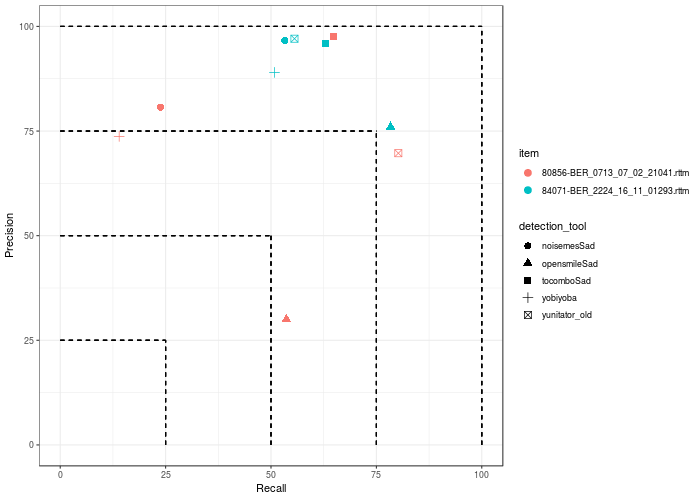

In [819]:
%%R -w 700 -h 500
p1 = ggplot(detection_df) + coord_cartesian(xlim = c(0,100), ylim = c(0,100)
) + geom_point(aes(x=detection.recall.., y=detection.precision.., 
colour=item, shape=detection_tool), size=3) + theme_bw() + xlab('Recall'
) + ylab('Precision') 

for (grid_line in c(25,50,75,100)){
    p1 <- (p1 + geom_segment(x=0, y=grid_line, xend=grid_line, yend=grid_line,
    linetype="dashed", alpha=.5) + geom_segment(x=grid_line, y=0, xend=grid_line,
    yend=grid_line, linetype="dashed", alpha=.5)) 
}

print(p1)
ggsave('figures/sad_precision_recall_tradeoff.pdf', width=8, height=5)

In [675]:
diarization_tools = ['diartk_noisemesSad','diartk_opensmileSad','diartk_tocomboSad',
    'yobiyoba','yunitator_old']

In [676]:
diarization_df = getTableForMetric(diarization_tools,'diaer')
%R -i diarization_df
diarization_df

/home/stephan/.local/lib/python3.5/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


,item,diarization error rate %,total,correct,correct %,false alarm,false alarm %,missed detection,missed detection %,confusion,confusion %,file,detection_tool
0,80856-BER_0713_07_02_21041.rttm,95.084991,75.89,7.81,10.291211,4.08,5.376202,59.05,77.809988,9.03,11.898801,80856-BER_0713_07_02_21041,diartk_noisemesSad
1,84071-BER_2224_16_11_01293.rttm,89.943362,224.23,26.47,11.804843,3.92,1.748205,114.60,51.108237,83.16,37.086920,84071-BER_2224_16_11_01293,diartk_noisemesSad
0,80856-BER_0713_07_02_21041.rttm,183.792331,75.89,24.82,32.705231,88.41,116.497562,37.99,50.059296,13.08,17.235472,80856-BER_0713_07_02_21041,diartk_opensmileSad
1,84071-BER_2224_16_11_01293.rttm,114.150649,224.23,19.13,8.531419,50.86,22.682068,63.25,28.207644,141.85,63.260937,84071-BER_2224_16_11_01293,diartk_opensmileSad
0,80856-BER_0713_07_02_21041.rttm,84.029516,75.89,13.31,17.538543,1.19,1.568059,30.02,39.557254,32.56,42.904203,80856-BER_0713_07_02_21041,diartk_tocomboSad
1,84071-BER_2224_16_11_01293.rttm,63.042412,224.23,88.44,39.441645,5.57,2.484057,94.72,42.242340,41.07,18.316015,84071-BER_2224_16_11_01293,diartk_tocomboSad
0,80856-BER_0713_07_02_21041.rttm,92.041112,75.89,9.54,12.570826,3.50,4.611938,66.07,87.060219,0.28,0.368955,80856-BER_0713_07_02_21041,yobiyoba
1,84071-BER_2224_16_11_01293.rttm,65.241047,224.23,90.78,40.485216,12.84,5.726263,120.27,53.636891,13.18,5.877893,84071-BER_2224_16_11_01293,yobiyoba
0,80856-BER_0713_07_02_21041.rttm,71.840822,75.89,45.85,60.416392,24.48,32.257214,19.57,25.787324,10.47,13.796284,80856-BER_0713_07_02_21041,yunitator_old
1,84071-BER_2224_16_11_01293.rttm,65.129554,224.23,81.63,36.404585,3.44,1.534139,110.57,49.310975,32.03,14.284440,84071-BER_2224_16_11_01293,yunitator_old


 [1] "item"                     "diarization.error.rate.."
 [3] "total"                    "correct"                 
 [5] "correct.."                "false.alarm"             
 [7] "false.alarm.."            "missed.detection"        
 [9] "missed.detection.."       "confusion"               
[11] "confusion.."              "file"                    
[13] "detection_tool"          


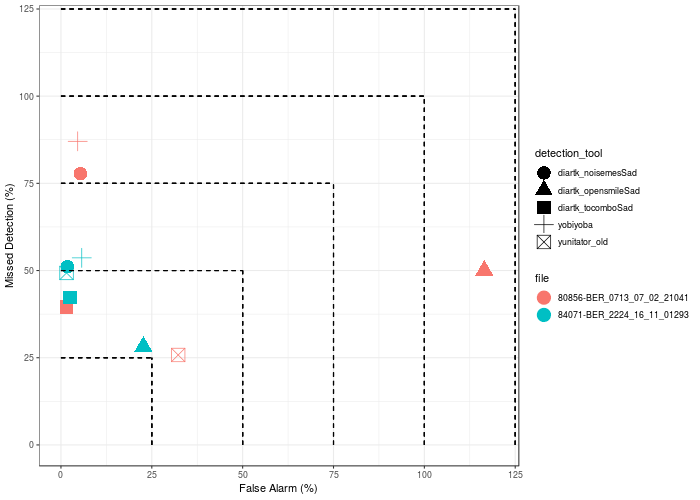

In [821]:
%%R -h 500 -w 700
print(names(diarization_df))
p1 = ggplot(diarization_df) + geom_point(aes(x=false.alarm.., y=missed.detection.., colour=file, 
shape = detection_tool), size=6) + coord_cartesian(xlim=c(0,120), ylim=c(0,120)
) + theme_bw() + ylab('Missed Detection (%)')+ xlab('False Alarm (%)')

for (grid_line in c(25,50,75,100, 125)){
    p1 <- (p1 + geom_segment(x=0, y=grid_line, xend=grid_line, yend=grid_line,
    linetype="dashed", alpha=.5) + geom_segment(x=grid_line, y=0, xend=grid_line,
    yend=grid_line, linetype="dashed", alpha=.5)) 
}



print(p1)
ggsave('figures/diarization_falsealarm_misseddetection.pdf', width=8, height=5)

 [1] "item"                     "diarization.error.rate.."
 [3] "total"                    "correct"                 
 [5] "correct.."                "false.alarm"             
 [7] "false.alarm.."            "missed.detection"        
 [9] "missed.detection.."       "confusion"               
[11] "confusion.."              "file"                    
[13] "detection_tool"          


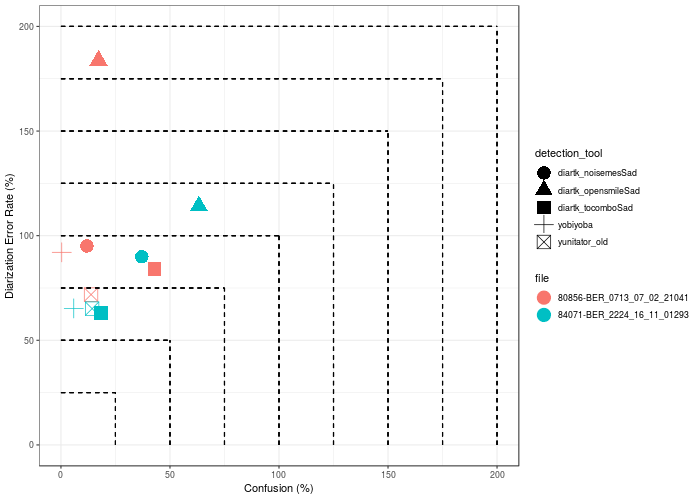

In [827]:
%%R -h 500 -w 700
print(names(diarization_df))
p1 = ggplot(diarization_df) + geom_point(aes(x=confusion.., y=diarization.error.rate.., colour=file, 
shape = detection_tool), size=6
) + theme_bw() + ylab('Diarization Error Rate (%)')+ xlab('Confusion (%)')

for (grid_line in c(25,50,75,100, 125, 150, 175,200)){
    p1 <- (p1 + geom_segment(x=0, y=grid_line, xend=grid_line, yend=grid_line,
    linetype="dashed", alpha=.5) + geom_segment(x=grid_line, y=0, xend=grid_line,
    yend=grid_line, linetype="dashed", alpha=.5)) 
}

p1 = p1 + coord_cartesian(xlim=c(0,200), ylim=c(0,200))

print(p1)
ggsave('figures/diarization_confusion_errrate.pdf', width=8, height=5)

# Word Error Rate

In [648]:
import re
import string
from jiwer import wer

def getYobiYobaWords(recording):
    xml_path = dataPath+recording+'.mp3_eng-usa_6.0.xml'
    word_df = readYobiYoba(xml_path, returnType = 'words')
    wordstring = ' '.join([x.lower() for x in word_df.text])
    wordstring = wordstring.translate(str.maketrans('', '', string.punctuation))
    wordstring = re.sub(r' +', ' ', wordstring)    
    return(wordstring.strip())

def getGoldStandardWords(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    wordstring = ' '.join([x.text.lower() for x in root.iter('ANNOTATION_VALUE') if x.text is not None])
    wordstring = wordstring.translate(str.maketrans('', '', string.punctuation))    
    wordstring = re.sub(r' +', ' ', wordstring)    
    wordstring = re.sub(r'\\[.*?\\]', '', wordstring)    
    wordstring = re.sub(r'\\{', '', wordstring)    
    wordlist = re.sub(r'\\}', '', wordstring).split(' ')    
    excludes = ['0','n','y','zzz','c','w','l','m','a','u','xxx', 'mm','pa','1']
    wordlist = [x for x in wordlist if x not in excludes]
    print('Processed:')
    print(wordlist)
    return(' '.join(wordlist))
    
def computeWER(recording):
    gs_for_file = {
        "80856-BER_0713_07_02_21041": "121251-BER_0713_07_02_21041-CP.eaf",
        "84071-BER_2224_16_11_01293": "121253-BER_2224_16_11_01293-CP.eaf"
    }
    
    xml_path = '/shared_hd1/VMs/DiViMe/data/'+gs_for_file[recording]
    yy_words = getYobiYobaWords(recording)
    gs_words = getGoldStandardWords(xml_path)
    print('Hypothesized annotation:')
    print(yy_words)
    print('Gold Standard Annotation:')
    print(gs_words)
    print(wer(gs_words,yy_words))

In [649]:
computeWER('80856-BER_0713_07_02_21041')

Processed:
['yeah', 'imitates', 'imitates', 'okay', 'you', 'want', 'food', 'you', 'want', 'bottle', 'oh', 'oh', 'no', 'oh', 'my', 'goodness', 'oh', 'oh', 'no', 'your', 'life', 'is', 'horrible', 'oh', 'oh', 'jeez', 'oh', 'no', 'oh', 'yeah', 'were', 'gonna', 'do', 'it', 'in', 'one', 'oh', 'i', 'missed', 'some', 'two', 'three', 'yeah', 'oh', 'boy', 'okay', 'okay', 'here', 'we', 'go', 'heres', 'your', 'oh', 'i', 'know', 'i', 'know', 'i', 'know', 'i', 'know', 'oh', 'boy', 'oh', 'boy']
Hypothesized annotation:
has oh boy oh here we go heres your oh i know i know no no oh boy oh boy yes yes
Gold Standard Annotation:
yeah imitates imitates okay you want food you want bottle oh oh no oh my goodness oh oh no your life is horrible oh oh jeez oh no oh yeah were gonna do it in one oh i missed some two three yeah oh boy okay okay here we go heres your oh i know i know i know i know oh boy oh boy
0.7846153846153846


In [650]:
computeWER('84071-BER_2224_16_11_01293')

Processed:
['what', 'color', 'did', 'it', 'turn', 'his', 'shoes', 'red', 'did', 'pete', 'cry', 'goodness', 'no', 'he', 'kept', 'walking', 'along', 'and', 'singing', 'his', 'song', 'i', 'love', 'my', 'red', 'shoes', 'sings', 'i', 'love', 'my', 'red', 'shoes', 'sings', 'i', 'love', 'my', 'red', 'shoes', 'sings', 'oh', 'no', 'pete', 'stepped', 'in', 'large', 'pile', 'of', 'blueberries', 'what', 'color', 'did', 'it', 'turn', 'his', 'shoes', 'blueberries', 'turned', 'his', 'shoes', 'blue', 'did', 'pete', 'cry', 'what', 'mmhm', 'did', 'pete', 'cry', 'goodness', 'no', 'he', 'kept', 'walking', 'along', 'and', 'singing', 'his', 'song', 'i', 'love', 'my', 'blue', 'shoes', 'sings', 'i', 'love', 'my', 'blue', 'shoes', 'sings', 'i', 'love', 'my', 'blue', 'shoes', 'sings', 'oh', 'no', 'pete', 'stepped', 'in', 'large', 'puddle', 'of', 'mud', 'laughs', 'what', 'color', 'did', 'it', 'turn', 'his', 'shoes', 'brown', 'did', 'pete', 'cry', 'oh', 'goodness', 'no', 'he', 'kept', 'walking', 'along', 'and', '